# Contest with embedding-based models

- Jakub Piwko
- Maciej Orsłowski
- Grzegorz Zakrzewski

# Read the data

https://huggingface.co/datasets/stanfordnlp/imdb

In [98]:
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [99]:
splits = {
    'train': 'plain_text/train-00000-of-00001.parquet',
    'test': 'plain_text/test-00000-of-00001.parquet',
    'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'
}
df_train = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])

## Inspect the data

In [100]:
print(f'Train size: {len(df_train)}')
print(f'Test size: {len(df_test)}')

Train size: 25000
Test size: 25000


In [101]:
df_train.head(10)

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
5,I would put this at the top of my list of film...,0
6,Whoever wrote the screenplay for this movie ob...,0
7,"When I first saw a glimpse of this movie, I qu...",0
8,"Who are these ""They""- the actors? the filmmake...",0
9,This is said to be a personal film for Peter B...,0


In [102]:
df_train['label'].value_counts()

,count
label,
0,12500
1,12500


In [103]:
df_test['label'].value_counts()

,count
label,
0,12500
1,12500


Positive words


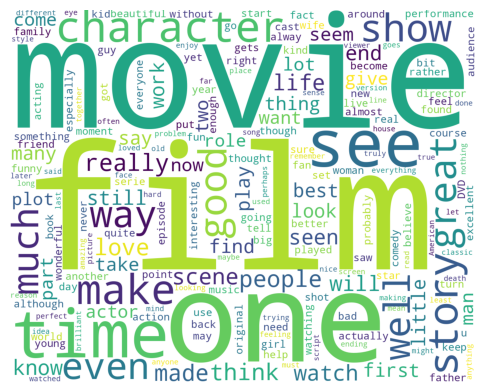

Negative words


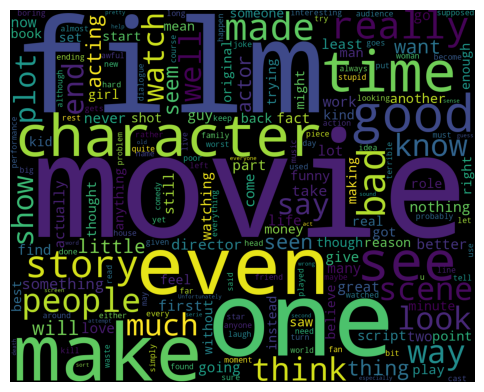

In [104]:
# ~ 1min
train_pos = df_train[df_train['label'] == 1]
train_pos = train_pos['text']
train_neg = df_train[df_train['label'] == 0]
train_neg = train_neg['text']


def wordcloud_draw(data, color):
    words = ' '.join(data)
    words_clean = words.replace('<br />', ' ')
    wordcloud = WordCloud(
        stopwords=STOPWORDS,
        background_color=color,
        width=1250,
        height=1000,
    )
    wordcloud = wordcloud.generate(words_clean)
    plt.figure(1, figsize=(6, 6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(train_pos, 'white')
print("============================================")
print("Negative words")
wordcloud_draw(train_neg, 'black')

## Preprocess

In [105]:
nltk.download('stopwords')
nltk.download('punkt')

stopwords_set = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
def preprocess(df: pd.DataFrame) -> list[tuple[str, int]]:
    reviews_preprocessed = []

    for index, row in df.iterrows():
        # remove br tags and special characters
        text_no_br = row['text'].replace('<br />', ' ')
        text_clean = re.sub(r'\W', ' ', text_no_br.lower())
        # split into words and filter
        words = word_tokenize(text_clean)
        words_filtered = [word for word in words if len(word) >= 3]
        words_without_stopwords = [word for word in words_filtered
                                  if not word in stopwords_set]
        reviews_preprocessed.append((words_without_stopwords, row['label']))

    return reviews_preprocessed

In [107]:
train_reviews = preprocess(df_train)
test_reviews = preprocess(df_test)

In [108]:
train_reviews[2][1]

0

In [109]:
train_reviews[0]

(['rented',
  'curious',
  'yellow',
  'video',
  'store',
  'controversy',
  'surrounded',
  'first',
  'released',
  '1967',
  'also',
  'heard',
  'first',
  'seized',
  'customs',
  'ever',
  'tried',
  'enter',
  'country',
  'therefore',
  'fan',
  'films',
  'considered',
  'controversial',
  'really',
  'see',
  'plot',
  'centered',
  'around',
  'young',
  'swedish',
  'drama',
  'student',
  'named',
  'lena',
  'wants',
  'learn',
  'everything',
  'life',
  'particular',
  'wants',
  'focus',
  'attentions',
  'making',
  'sort',
  'documentary',
  'average',
  'swede',
  'thought',
  'certain',
  'political',
  'issues',
  'vietnam',
  'war',
  'race',
  'issues',
  'united',
  'states',
  'asking',
  'politicians',
  'ordinary',
  'denizens',
  'stockholm',
  'opinions',
  'politics',
  'sex',
  'drama',
  'teacher',
  'classmates',
  'married',
  'men',
  'kills',
  'curious',
  'yellow',
  'years',
  'ago',
  'considered',
  'pornographic',
  'really',
  'sex',
  'nudi

# Training models

## 1. Model FastText

In [110]:
# %pip install fasttext

In [111]:
import fasttext

In [112]:
def save_fasttext_format(data: list[tuple[list[str], int]], filename: str):
    with open(filename, 'w') as f:
        for words, label in data:
            label_str = f"__label__{label + 1}"
            text = " ".join(words)
            f.write(f"{label_str} {text}\n")


In [113]:
save_fasttext_format(train_reviews, 'train_fasttext.txt')
save_fasttext_format(test_reviews, 'test_fasttext.txt')

In [114]:
model = fasttext.train_supervised(input='train_fasttext.txt', epoch=100, lr=0.02, wordNgrams=2, verbose=2, minCount=1, dim=40)

In [115]:
result_tr = model.test('train_fasttext.txt')

print('Train set')
print(f"Precision: {result_tr[1]}, Recall: {result_tr[2]}")
f1_tr = 2 / ((1/result_tr[1]) + (1/result_tr[2]))
print(f"F1 score: {f1_tr}")

Train set
Precision: 0.98188, Recall: 0.98188
F1 score: 0.98188


In [116]:
result_ts = model.test('test_fasttext.txt')

print("Test set")
print(f"Precision: {result_ts[1]}, Recall: {result_ts[2]}")
f1_ts = 2 / ((1/result_ts[1]) + (1/result_ts[2]))
print(f"F1 score: {f1_ts}")

Test set
Precision: 0.88272, Recall: 0.88272
F1 score: 0.88272


In [117]:
fasttext_results_train = [{
        'Data Processing': 'fastText',
        'Model': 'fastText',
        'Precision': result_tr[1],
        'Recall': result_tr[2],
        'F1 Score': f1_tr,
    }]

fasttext_results_test= [{
        'Data Processing': 'fastText',
        'Model': 'fastText',
        'Precision': result_ts[1],
        'Recall': result_ts[2],
        'F1 Score': f1_ts,
    }]

In [118]:
pd.DataFrame(fasttext_results_train)

,Data Processing,Model,Precision,Recall,F1 Score
0,fastText,fastText,0.98188,0.98188,0.98188


In [119]:
pd.DataFrame(fasttext_results_test)

,Data Processing,Model,Precision,Recall,F1 Score
0,fastText,fastText,0.88272,0.88272,0.88272


## 2. Word2Vec

In [120]:
from gensim.models import Word2Vec

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, precision_score, recall_score

Generate feature vectors for all words

In [121]:
# ~ 40s
train_reviews_no_labels = [review for review, label in train_reviews]
word2vec = Word2Vec(
    train_reviews_no_labels,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    seed=24,
)

In [122]:
# ~ 20s
def get_avg_word_vector(words: list[str]):
    word_vectors = [word2vec.wv[word] for word in words if word in word2vec.wv]
    if len(word_vectors) == 0:
        # this word is not in the model's vocabulary - return all zeros
        return np.zeros(word2vec.vector_size)
    # mean of all features for this word
    return np.mean(word_vectors, axis=0)


X_train = np.array([get_avg_word_vector(words) for words, label in train_reviews])
y_train = np.array([label for words, label in train_reviews])
X_test = np.array([get_avg_word_vector(words) for words, label in test_reviews])
y_test = np.array([label for words, label in test_reviews])

Train models on the features

In [123]:
word2vec_results_train = []
word2vec_results_test = []

def save_word2vec_model_results(model_name, model, x, y, where_to_save: list):
    y_pred = model.predict(x)

    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Append results to the list
    where_to_save.append({
        'Data Processing': 'Word2Vec',
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
    })


models = {
    'Logistic Regression': LogisticRegression(random_state=28, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=28, max_depth=7),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(
        random_state=28,
        max_depth=7,
        learning_rate=0.01,
        alpha=0.1,
        lambda_=1.0,
    ),
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    save_word2vec_model_results(model_name, model, X_train, y_train, word2vec_results_train)
    save_word2vec_model_results(model_name, model, X_test, y_test, word2vec_results_test)

word2vec_results_train = pd.DataFrame(word2vec_results_train)
word2vec_results_test = pd.DataFrame(word2vec_results_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:23:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


In [124]:
word2vec_results_train

,Data Processing,Model,Precision,Recall,F1 Score
0,Word2Vec,Logistic Regression,0.807698,0.80764,0.807631
1,Word2Vec,Random Forest,0.796210,0.79608,0.796058
2,Word2Vec,SVM,0.816082,0.81584,0.815805
3,Word2Vec,XGBoost,0.829466,0.82936,0.829346


In [125]:
word2vec_results_test

,Data Processing,Model,Precision,Recall,F1 Score
0,Word2Vec,Logistic Regression,0.808369,0.80836,0.808359
1,Word2Vec,Random Forest,0.758938,0.75892,0.758916
2,Word2Vec,SVM,0.813736,0.81364,0.813626
3,Word2Vec,XGBoost,0.761642,0.76164,0.761640


## 3. Sentence-BERT

In [ ]:
# %pip install sentence_transformers

In [131]:
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [133]:
def prepare_sentences(data):
    sentences = [" ".join(words) for words, label in data]
    labels = [label for words, label in data]
    return sentences, labels

train_sentences, train_labels = prepare_sentences(train_reviews)
test_sentences, test_labels = prepare_sentences(test_reviews)

train_embeddings = model.encode(train_sentences, convert_to_tensor=True)
test_embeddings = model.encode(test_sentences, convert_to_tensor=True)

In [137]:
sentencebert_results_train = []
sentencebert_results_test = []

def save_sentencebert_model_results(model_name, model, x_embeddings, y, where_to_save: list):
    y_pred = model.predict(x_embeddings)

    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    where_to_save.append({
        'Data Processing': 'Sentence-BERT',
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
    })

In [142]:
for model_name, model in models.items():
    model.fit(train_embeddings, train_labels)
    save_sentencebert_model_results(model_name, model, train_embeddings, train_labels, sentencebert_results_train)
    save_sentencebert_model_results(model_name, model, test_embeddings, test_labels, sentencebert_results_test)

sentencebert_results_train = pd.DataFrame(sentencebert_results_train)
sentencebert_results_test = pd.DataFrame(sentencebert_results_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:53:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


In [143]:
sentencebert_results_train

,Data Processing,Model,Precision,Recall,F1 Score
0,Sentence-BERT,Logistic Regression,0.828721,0.82864,0.828629
1,Sentence-BERT,Random Forest,0.826519,0.82604,0.825976
2,Sentence-BERT,SVM,0.903952,0.90392,0.903918
3,Sentence-BERT,XGBoost,0.847430,0.84708,0.847041


In [144]:
sentencebert_results_test

,Data Processing,Model,Precision,Recall,F1 Score
0,Sentence-BERT,Logistic Regression,0.820322,0.82032,0.820320
1,Sentence-BERT,Random Forest,0.766243,0.76604,0.765995
2,Sentence-BERT,SVM,0.829462,0.82944,0.829437
3,Sentence-BERT,XGBoost,0.749470,0.74932,0.749282


# Summarise all our results

In [145]:
all_results_test = pd.concat(
    [word2vec_results_test, pd.DataFrame(fasttext_results_test), sentencebert_results_test],
    ignore_index=True,
)
all_results_test

,Data Processing,Model,Precision,Recall,F1 Score
0,Word2Vec,Logistic Regression,0.808369,0.80836,0.808359
1,Word2Vec,Random Forest,0.758938,0.75892,0.758916
2,Word2Vec,SVM,0.813736,0.81364,0.813626
3,Word2Vec,XGBoost,0.761642,0.76164,0.761640
4,fastText,fastText,0.882720,0.88272,0.882720
5,Sentence-BERT,Logistic Regression,0.820322,0.82032,0.820320
6,Sentence-BERT,Random Forest,0.766243,0.76604,0.765995
7,Sentence-BERT,SVM,0.829462,0.82944,0.829437
8,Sentence-BERT,XGBoost,0.749470,0.74932,0.749282
